# Análise influência do clima no consumo de energia Residencial

## Preparação do Dataset

### Import das bibliotecas

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor

### Uso do datase do Kaggle

In [59]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jeanmidev/smart-meters-in-london")

print("Path to dataset files:", path)

Path to dataset files: /home/eduardofuncao/.cache/kagglehub/datasets/jeanmidev/smart-meters-in-london/versions/21


### Carrega o Dataset

In [60]:
residencias_info = pd.read_csv(path + '/informations_households.csv')
clima_diario = pd.read_csv(path + '/weather_daily_darksky.csv')
energia_diario = pd.read_csv(path + '/daily_dataset.csv')
feriados = pd.read_csv(path + '/uk_bank_holidays.csv')

## Tratamento dos dados

In [61]:
print("Residências incluídas no dataset")
residencias_info.head()

Residências incluídas no dataset


,LCLid,stdorToU,Acorn,Acorn_grouped,file
0,MAC005492,ToU,ACORN-,ACORN-,block_0
1,MAC001074,ToU,ACORN-,ACORN-,block_0
2,MAC000002,Std,ACORN-A,Affluent,block_0
3,MAC003613,Std,ACORN-A,Affluent,block_0
4,MAC003597,Std,ACORN-A,Affluent,block_0


In [62]:
print('Informações diárias sobre o clima')
clima_diario.head()

Informações diárias sobre o clima


,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,...,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase
0,11.96,2011-11-11 23:00:00,123,fog,9.40,2011-11-11 07:00:00,0.79,3.88,1016.08,2011-11-11 07:00:00,...,10.87,2011-11-11 07:12:14,2011-11-11 19:00:00,2011-11-11 11:00:00,Foggy until afternoon.,2011-11-11 19:00:00,6.48,2011-11-11 23:00:00,2011-11-11 19:00:00,0.52
1,8.59,2011-12-11 14:00:00,198,partly-cloudy-day,4.49,2011-12-11 01:00:00,0.56,3.94,1007.71,2011-12-11 02:00:00,...,8.59,2011-12-11 07:57:02,2011-12-11 14:00:00,2011-12-11 12:00:00,Partly cloudy throughout the day.,2011-12-12 07:00:00,0.11,2011-12-11 20:00:00,2011-12-12 08:00:00,0.53
2,10.33,2011-12-27 02:00:00,225,partly-cloudy-day,5.47,2011-12-27 23:00:00,0.85,3.54,1032.76,2011-12-27 22:00:00,...,10.33,2011-12-27 08:07:06,2011-12-27 14:00:00,2011-12-27 00:00:00,Mostly cloudy throughout the day.,2011-12-27 23:00:00,5.59,2011-12-27 02:00:00,2011-12-28 00:00:00,0.10
3,8.07,2011-12-02 23:00:00,232,wind,3.69,2011-12-02 07:00:00,0.32,3.00,1012.12,2011-12-02 07:00:00,...,7.36,2011-12-02 07:46:09,2011-12-02 12:00:00,2011-12-02 10:00:00,Partly cloudy throughout the day and breezy ov...,2011-12-02 19:00:00,0.46,2011-12-02 12:00:00,2011-12-02 19:00:00,0.25
4,8.22,2011-12-24 23:00:00,252,partly-cloudy-night,2.79,2011-12-24 07:00:00,0.37,4.46,1028.17,2011-12-24 07:00:00,...,7.93,2011-12-24 08:06:15,2011-12-24 15:00:00,2011-12-24 13:00:00,Mostly cloudy throughout the day.,2011-12-24 19:00:00,-0.51,2011-12-24 23:00:00,2011-12-24 20:00:00,0.99


In [63]:
print('Informações sobre consumo diário por casa')
energia_diario.head()

Informações sobre consumo diário por casa


,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,MAC000131,2011-12-15,0.4850,0.432045,0.868,22,0.239146,9.505,0.072
1,MAC000131,2011-12-16,0.1415,0.296167,1.116,48,0.281471,14.216,0.031
2,MAC000131,2011-12-17,0.1015,0.189812,0.685,48,0.188405,9.111,0.064
3,MAC000131,2011-12-18,0.1140,0.218979,0.676,48,0.202919,10.511,0.065
4,MAC000131,2011-12-19,0.1910,0.325979,0.788,48,0.259205,15.647,0.066


In [64]:
residencias_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5566 entries, 0 to 5565
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   LCLid          5566 non-null   object
 1   stdorToU       5566 non-null   object
 2   Acorn          5566 non-null   object
 3   Acorn_grouped  5566 non-null   object
 4   file           5566 non-null   object
dtypes: object(5)
memory usage: 217.5+ KB


In [65]:
clima_diario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882 entries, 0 to 881
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   temperatureMax               882 non-null    float64
 1   temperatureMaxTime           882 non-null    object 
 2   windBearing                  882 non-null    int64  
 3   icon                         882 non-null    object 
 4   dewPoint                     882 non-null    float64
 5   temperatureMinTime           882 non-null    object 
 6   cloudCover                   881 non-null    float64
 7   windSpeed                    882 non-null    float64
 8   pressure                     882 non-null    float64
 9   apparentTemperatureMinTime   882 non-null    object 
 10  apparentTemperatureHigh      882 non-null    float64
 11  precipType                   882 non-null    object 
 12  visibility                   882 non-null    float64
 13  humidity            

In [66]:
energia_diario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3510433 entries, 0 to 3510432
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   LCLid          object 
 1   day            object 
 2   energy_median  float64
 3   energy_mean    float64
 4   energy_max     float64
 5   energy_count   int64  
 6   energy_std     float64
 7   energy_sum     float64
 8   energy_min     float64
dtypes: float64(6), int64(1), object(2)
memory usage: 241.0+ MB


Avaliando os tipos de dados, vemos que será necessário fazer um tratamento nas colunas de data para evitar problemas futuros

### Conversão do tipo de colunas de data

In [67]:
energia_diario['date'] = pd.to_datetime(energia_diario['day'])
clima_diario['date'] = pd.to_datetime(clima_diario['time'])
feriados['date'] = pd.to_datetime(feriados['Bank holidays'])

In [68]:
print(energia_diario['date'].dtypes)
energia_diario[['date', 'day']].head()

datetime64[ns]


,date,day
0,2011-12-15,2011-12-15
1,2011-12-16,2011-12-16
2,2011-12-17,2011-12-17
3,2011-12-18,2011-12-18
4,2011-12-19,2011-12-19


In [69]:
print(clima_diario['date'].dtypes)
clima_diario[['date', 'time']].head()

datetime64[ns]


,date,time
0,2011-11-11,2011-11-11 00:00:00
1,2011-12-11,2011-12-11 00:00:00
2,2011-12-27,2011-12-27 00:00:00
3,2011-12-02,2011-12-02 00:00:00
4,2011-12-24,2011-12-24 00:00:00


In [70]:
print(feriados['date'].dtypes)
feriados[['date', 'Bank holidays']].head()

datetime64[ns]


,date,Bank holidays
0,2012-12-26,2012-12-26
1,2012-12-25,2012-12-25
2,2012-08-27,2012-08-27
3,2012-05-06,2012-05-06
4,2012-04-06,2012-04-06


### Remoção de valores nulos e duplicados

In [71]:
print("valores nulos em residencia_diario")
print(residencias_info.isnull().sum())
print("valores nulos em clima_diario")
print(clima_diario.isnull().sum())
print("valores nulos em energia_diario")
print(energia_diario.isnull().sum())

valores nulos em residencia_diario
LCLid            0
stdorToU         0
Acorn            0
Acorn_grouped    0
file             0
dtype: int64
valores nulos em clima_diario
temperatureMax                 0
temperatureMaxTime             0
windBearing                    0
icon                           0
dewPoint                       0
temperatureMinTime             0
cloudCover                     1
windSpeed                      0
pressure                       0
apparentTemperatureMinTime     0
apparentTemperatureHigh        0
precipType                     0
visibility                     0
humidity                       0
apparentTemperatureHighTime    0
apparentTemperatureLow         0
apparentTemperatureMax         0
uvIndex                        1
time                           0
sunsetTime                     0
temperatureLow                 0
temperatureMin                 0
temperatureHigh                0
sunriseTime                    0
temperatureHighTime            0
uv

In [72]:
print("valores duplicados em residencias_info")
print(residencias_info.duplicated().sum())
print("valores duplicados em clima_diario")
print(clima_diario.duplicated().sum())
print("valores duplicados em energia_diario")
print(energia_diario.duplicated().sum())

valores duplicados em residencias_info
0
valores duplicados em clima_diario
0
valores duplicados em energia_diario
0


In [73]:
residencias_info.dropna(inplace=True)
clima_diario.dropna(inplace=True)
energia_diario.dropna(inplace=True)

In [74]:
print("valores nulos em residencia_diario")
print(residencias_info.isnull().sum())
print("valores nulos em clima_diario")
print(clima_diario.isnull().sum())
print("valores nulos em energia_diario")
print(energia_diario.isnull().sum())

valores nulos em residencia_diario
LCLid            0
stdorToU         0
Acorn            0
Acorn_grouped    0
file             0
dtype: int64
valores nulos em clima_diario
temperatureMax                 0
temperatureMaxTime             0
windBearing                    0
icon                           0
dewPoint                       0
temperatureMinTime             0
cloudCover                     0
windSpeed                      0
pressure                       0
apparentTemperatureMinTime     0
apparentTemperatureHigh        0
precipType                     0
visibility                     0
humidity                       0
apparentTemperatureHighTime    0
apparentTemperatureLow         0
apparentTemperatureMax         0
uvIndex                        0
time                           0
sunsetTime                     0
temperatureLow                 0
temperatureMin                 0
temperatureHigh                0
sunriseTime                    0
temperatureHighTime            0
uv

## Análise Exploratória

### Identificação de Outliers e Correlação

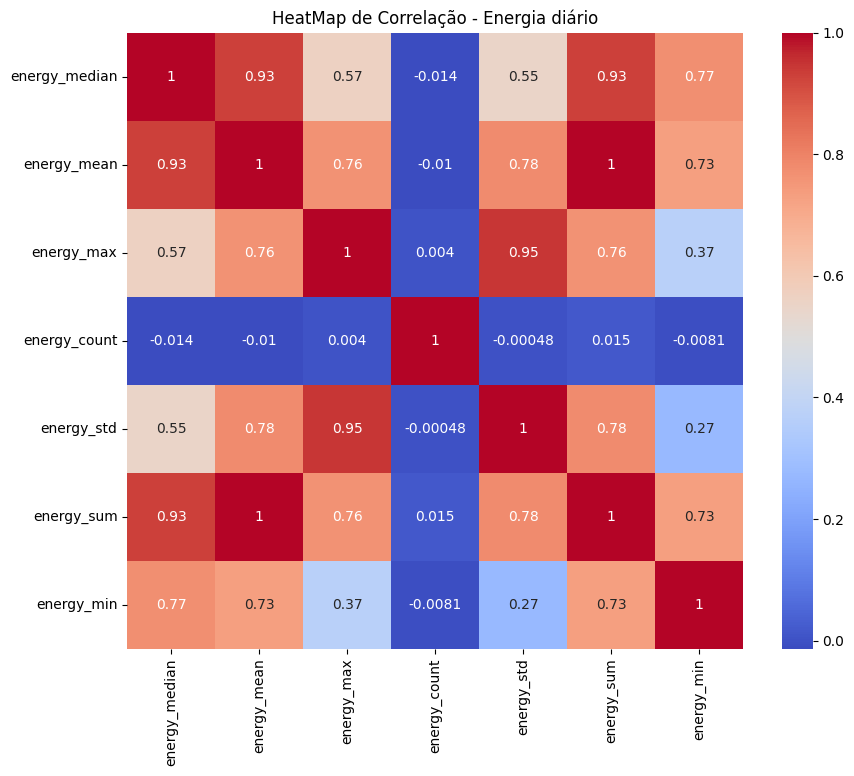

In [75]:
correlation_matrix = energia_diario.select_dtypes(include=['int64', 'float64']).corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('HeatMap de Correlação - Energia diário')
plt.show()

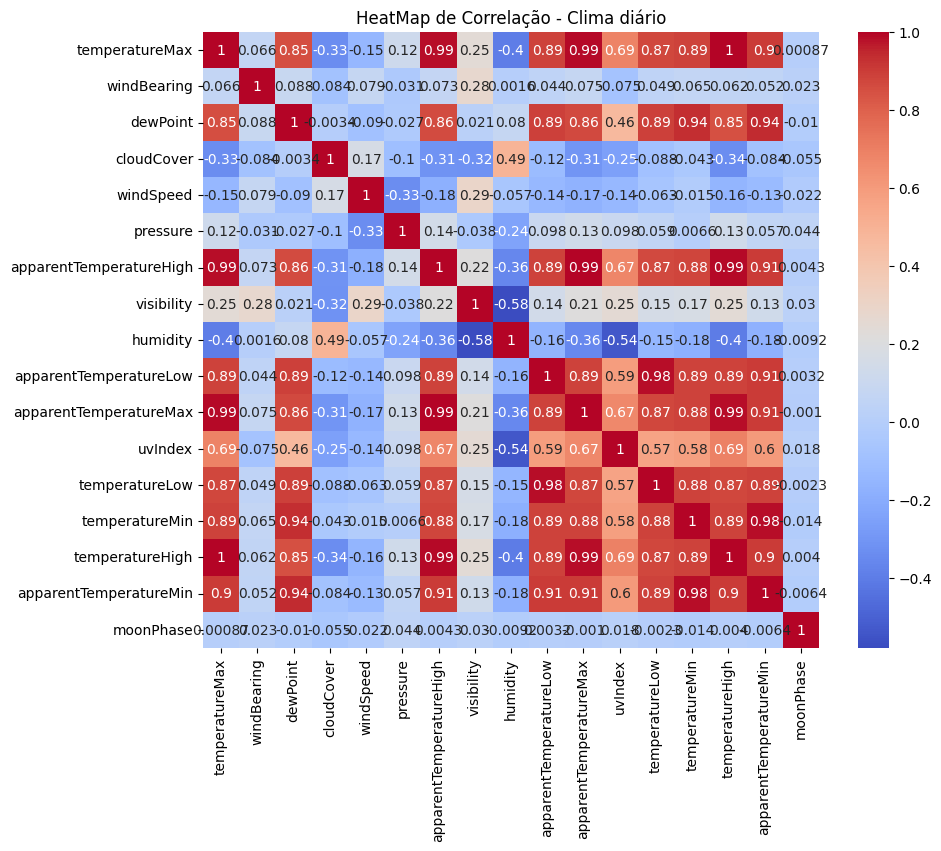

In [76]:
correlation_matrix = clima_diario.select_dtypes(include=['int64', 'float64']).corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('HeatMap de Correlação - Clima diário')
plt.show()

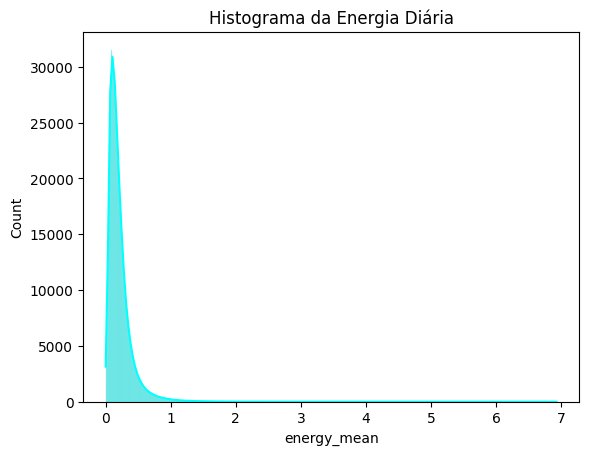

In [77]:
sns.histplot(energia_diario['energy_mean'], kde=True, color='cyan')
plt.title('Histograma da Energia Diária')
plt.show()

Text(0.5, 1.0, 'Histograma da Temperatura Máxima')

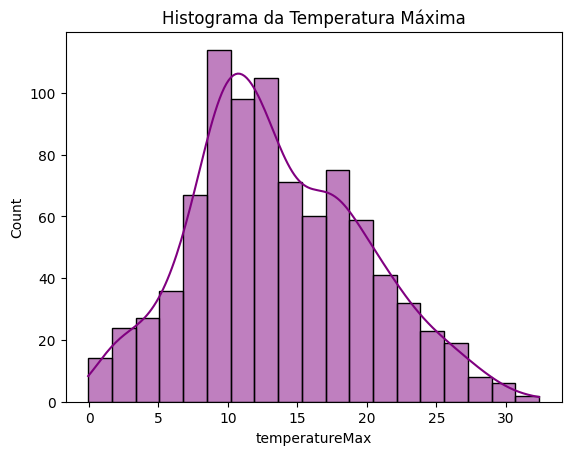

In [78]:
sns.histplot(clima_diario['temperatureMax'], kde=True, color='purple')
plt.title('Histograma da Temperatura Máxima')

### Algumas conclusões

Existe uma forte correlação entre todas as features de temperatura com a coluna de Temperatura Máxima. Provavelmente podemos manter somente esta coluna em detrimento das outras, sem perda significativa.

De forma similar, as colunas de média, mediana e soma da energia também parecem ser fortemente correlacionados.

O histograma da temperatura máxima demonstra que os dados se assemelham a uma distribuição normal bem comportada e praticamente simétrica, com um leve desvio para temperaturas menores. Histogramas de outras features relacionadas à temperatura se comportam de maneira semelhante.

Os dados de energia média apresentam um comportamento interessante. A grande maioria dos dados esta alocado na faixa de 0 a 1, mas existem alguns dados, com frequência bem menor, que podem ser até 7 vezes maiores. A seguir está representado o histograma com dados de média de energia somente entre 0 e 1.

Text(0.5, 1.0, 'Histograma da Média de Energia (filtrado para valores entre 0 e 1)')

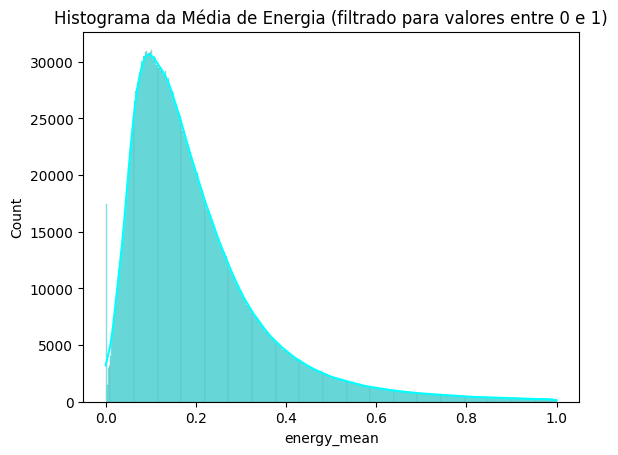

In [79]:
energia_diario_filtrado = energia_diario.loc[energia_diario['energy_mean'] <= 1]
sns.histplot(energia_diario_filtrado['energy_mean'], kde=True, color='cyan')
plt.title('Histograma da Média de Energia (filtrado para valores entre 0 e 1)')

Observamos que neste caso, a distribuição observada pode ser melhor avaliada. Existe uma alta concentradação para valores de energia na faixa de 0.1 a 0.2, sendo que as frequências caem exponenciamente na medida em que a energia aumenta. Embora os dados indiquem a possibilidade da presença de alguns outliers, não podemos descartar com autoridade nenhum dos valores em primeira análise. Mesmo assim, a frequência baixa de valores mais altos provavelmente não afetará os resultados do nosso modelo de regressão.

Há também uma quantidade considerável de dados em que a média do consumo de energia foi 0 (zero) ao longo do dia. Esse comportamento é esperado nesse tipo de dataset, uma vez que faltas de energia que durem durante todo um dia podem ser comuns.

### União das tabelas

In [80]:
df = pd.merge(energia_diario, clima_diario, on='date', how='inner')
print(df.shape)
df.head()

(1534525, 42)


,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min,date,...,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase
0,MAC000131,2011-12-15,0.4850,0.432045,0.868,22,0.239146,9.505,0.072,2011-12-15,...,7.97,2011-12-15 08:00:46,2011-12-15 14:00:00,2011-12-15 11:00:00,Partly cloudy throughout the day and breezy in...,2011-12-16 08:00:00,1.07,2011-12-15 21:00:00,2011-12-16 08:00:00,0.66
1,MAC000131,2011-12-16,0.1415,0.296167,1.116,48,0.281471,14.216,0.031,2011-12-16,...,4.53,2011-12-16 08:01:35,2011-12-16 15:00:00,2011-12-16 11:00:00,Mostly cloudy throughout the day.,2011-12-17 08:00:00,-2.65,2011-12-16 00:00:00,2011-12-17 08:00:00,0.70
2,MAC000131,2011-12-17,0.1015,0.189812,0.685,48,0.188405,9.111,0.064,2011-12-17,...,5.35,2011-12-17 08:02:21,2011-12-17 14:00:00,2011-12-17 11:00:00,Partly cloudy throughout the day.,2011-12-18 07:00:00,-3.56,2011-12-17 15:00:00,2011-12-18 06:00:00,0.73
3,MAC000131,2011-12-18,0.1140,0.218979,0.676,48,0.202919,10.511,0.065,2011-12-18,...,5.49,2011-12-18 08:03:04,2011-12-18 14:00:00,2011-12-18 12:00:00,Partly cloudy until evening.,2011-12-19 01:00:00,-4.12,2011-12-18 14:00:00,2011-12-19 02:00:00,0.77
4,MAC000131,2011-12-19,0.1910,0.325979,0.788,48,0.259205,15.647,0.066,2011-12-19,...,6.64,2011-12-19 08:03:43,2011-12-19 19:00:00,2011-12-19 11:00:00,Partly cloudy throughout the day.,2011-12-20 04:00:00,-3.67,2011-12-19 19:00:00,2011-12-20 08:00:00,0.81


### Inclusão de dados sobre Feriados em Londres

No dataset, também existem informações sobre quais dias são feriados na cidade de Londres. Será adicionada uma coluna holiday na tabela, indicando se aquele dia é ou não feriado.

In [81]:
feriados['is_holiday'] = 1
feriados.head()

,Bank holidays,Type,date,is_holiday
0,2012-12-26,Boxing Day,2012-12-26,1
1,2012-12-25,Christmas Day,2012-12-25,1
2,2012-08-27,Summer bank holiday,2012-08-27,1
3,2012-05-06,Queen?s Diamond Jubilee (extra bank holiday),2012-05-06,1
4,2012-04-06,Spring bank holiday (substitute day),2012-04-06,1


In [82]:
df = pd.merge(df, feriados, on='date', how='left')
df.drop(columns=['Bank holidays', 'Type'], inplace=True)
df['is_holiday'] = df['is_holiday'].fillna(0)

count_zero = (df['is_holiday'] == 0).sum()
count_one = (df['is_holiday'] == 1).sum()

print(f"Dias sem feriados: {count_zero}")
print(f"Dias com feriado: {count_one}")

Dias sem feriados: 1496297
Dias com feriado: 38228


### Remoção dos dados com informação duplicada

In [83]:
df[['date', 'time', 'day']]

,date,time,day
0,2011-12-15,2011-12-15 00:00:00,2011-12-15
1,2011-12-16,2011-12-16 00:00:00,2011-12-16
2,2011-12-17,2011-12-17 00:00:00,2011-12-17
3,2011-12-18,2011-12-18 00:00:00,2011-12-18
4,2011-12-19,2011-12-19 00:00:00,2011-12-19
...,...,...,...
1534520,2014-02-23,2014-02-23 00:00:00,2014-02-23
1534521,2014-02-24,2014-02-24 00:00:00,2014-02-24
1534522,2014-02-25,2014-02-25 00:00:00,2014-02-25
1534523,2014-02-26,2014-02-26 00:00:00,2014-02-26


In [84]:
df.drop(columns=['day', 'time'], inplace=True)

In [85]:
df.head()

,LCLid,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min,date,temperatureMax,...,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase,is_holiday
0,MAC000131,0.4850,0.432045,0.868,22,0.239146,9.505,0.072,2011-12-15,7.97,...,2011-12-15 08:00:46,2011-12-15 14:00:00,2011-12-15 11:00:00,Partly cloudy throughout the day and breezy in...,2011-12-16 08:00:00,1.07,2011-12-15 21:00:00,2011-12-16 08:00:00,0.66,0.0
1,MAC000131,0.1415,0.296167,1.116,48,0.281471,14.216,0.031,2011-12-16,4.68,...,2011-12-16 08:01:35,2011-12-16 15:00:00,2011-12-16 11:00:00,Mostly cloudy throughout the day.,2011-12-17 08:00:00,-2.65,2011-12-16 00:00:00,2011-12-17 08:00:00,0.70,0.0
2,MAC000131,0.1015,0.189812,0.685,48,0.188405,9.111,0.064,2011-12-17,5.35,...,2011-12-17 08:02:21,2011-12-17 14:00:00,2011-12-17 11:00:00,Partly cloudy throughout the day.,2011-12-18 07:00:00,-3.56,2011-12-17 15:00:00,2011-12-18 06:00:00,0.73,0.0
3,MAC000131,0.1140,0.218979,0.676,48,0.202919,10.511,0.065,2011-12-18,5.49,...,2011-12-18 08:03:04,2011-12-18 14:00:00,2011-12-18 12:00:00,Partly cloudy until evening.,2011-12-19 01:00:00,-4.12,2011-12-18 14:00:00,2011-12-19 02:00:00,0.77,0.0
4,MAC000131,0.1910,0.325979,0.788,48,0.259205,15.647,0.066,2011-12-19,6.64,...,2011-12-19 08:03:43,2011-12-19 19:00:00,2011-12-19 11:00:00,Partly cloudy throughout the day.,2011-12-20 04:00:00,-3.67,2011-12-19 19:00:00,2011-12-20 08:00:00,0.81,0.0


Nossa feature target será a energia consumida ao longo de um dia (energy_sum). O restante das colunas será utilizado para treino, após redução de dimensionalidade através de PCA.

In [86]:
X = df.drop(columns=['energy_sum']).select_dtypes(include=['int64', 'float64'])
Y = df['energy_sum']

scaler = StandardScaler()
X_normalizado = scaler.fit_transform(X)

## Treino Inicial de modelos de Machine Learning

### PCA


Ao invés de remover colunas fortemente correlacionadas de forma manual, será aplicado o alogritmo PCA para diminuir a dimensão do conjunto de dados.

In [87]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_normalizado)
print("Componentes depois da análise PCA:", X_pca.shape[1])

Componentes depois da análise PCA: 13


### Árvore de Decisão com PCA

### Divisão das amostras de treino e teste

In [88]:
X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y, test_size=0.3, random_state=777)

In [89]:
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, Y_train)

DecisionTreeRegressor(random_state=42)

In [90]:
Y_pred = model.predict(X_test)

mae = mean_absolute_error(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 1.0871239382239475
Mean Squared Error (MSE): 3.4858818351886116
R-squared (R²): 0.9709308172542794


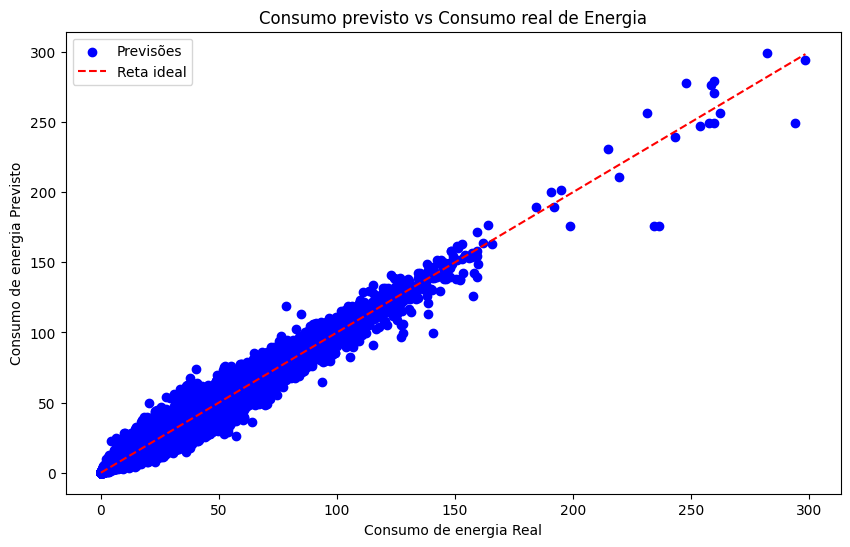

In [91]:
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, Y_pred, color='blue', label='Previsões')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linestyle='--', label='Reta ideal')
plt.xlabel('Consumo de energia Real')
plt.ylabel('Consumo de energia Previsto')
plt.title('Consumo previsto vs Consumo real de Energia')
plt.legend()
plt.show()

Para efeito de comparação, também será feito o treinamento do medelo com o dataset a priori da aplicação do PCA

### Árvore de decisão sem PCA

In [92]:
X_train, X_test, Y_train, Y_test = train_test_split(X_normalizado, Y, test_size=0.3, random_state=777)

In [93]:
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, Y_train)

DecisionTreeRegressor(random_state=42)

In [94]:
Y_pred = model.predict(X_test)

mae = mean_absolute_error(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 0.002058332798034988
Mean Squared Error (MSE): 0.013228724004742043
R-squared (R²): 0.9998896840989546


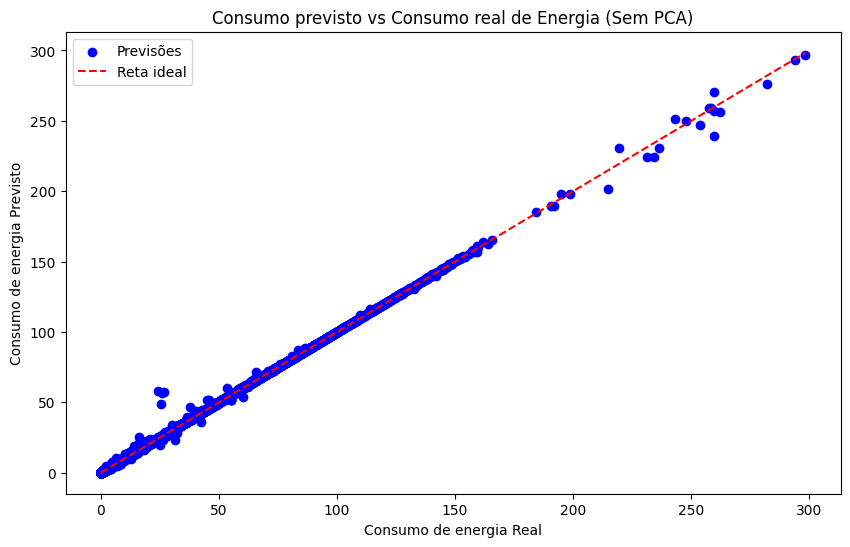

In [95]:
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, Y_pred, color='blue', label='Previsões')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linestyle='--', label='Reta ideal')
plt.xlabel('Consumo de energia Real')
plt.ylabel('Consumo de energia Previsto')
plt.title('Consumo previsto vs Consumo real de Energia (Sem PCA)')
plt.legend()
plt.show()

O resultados são interessantes. Conforme era esperado, a análise sem a utilização de redução de dimensionalidade obteve erros muito menores do que o treinamento do modelo utilizando PCA.

Embora os resultados parecam ser extraordinários, existe uma falha na forma como está sendo conduzida a seleção das features para teste: com exceção da coluna de consumo energético total, as outras colunas relacionadas a consumo energético estão sendo mantidas no treinamento e predição do modelo. Embora os resultados sejam muito bons devido a isso, esse método não replicaria uma utilização real, na qual não existe informação total a respeito do sistema.

Para simular um caso mais fáctivel, vamos remover as outras informações a respeito da energia do dataset, e tentaremo predizar o consumo de energia total somente com as variáveis relacioadas ao clima e a data.

## Treino final dos modelos de Machine Learning

Para comparação serão utilizados os seguintes modelos para o treinamento:
- Decision Tree
- Random Forest
- SGD
- Artificial Neural Network


### Remoção dos dados relacionados a energia do dataset

In [96]:
df.columns

Index(['LCLid', 'energy_median', 'energy_mean', 'energy_max', 'energy_count',
       'energy_std', 'energy_sum', 'energy_min', 'date', 'temperatureMax',
       'temperatureMaxTime', 'windBearing', 'icon', 'dewPoint',
       'temperatureMinTime', 'cloudCover', 'windSpeed', 'pressure',
       'apparentTemperatureMinTime', 'apparentTemperatureHigh', 'precipType',
       'visibility', 'humidity', 'apparentTemperatureHighTime',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex',
       'sunsetTime', 'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'sunriseTime', 'temperatureHighTime', 'uvIndexTime', 'summary',
       'temperatureLowTime', 'apparentTemperatureMin',
       'apparentTemperatureMaxTime', 'apparentTemperatureLowTime', 'moonPhase',
       'is_holiday'],
      dtype='object')

In [97]:
df.drop(columns=['energy_min', 'energy_max', 'energy_count'], inplace=True)

Algumas colunas relacionadas com dados históricos do consumo de energia, como média, mediana e desvio padrão serão mantidas. Em um caso real, elas poderiam ser abstraídas de dados passados.

### Sample de 20% dos dados para tornar execução mais rápida

In [98]:
df_sample = df.sample(frac=0.2, random_state=777)

### Target e Normalização

In [99]:
X = df_sample.drop(columns=['energy_sum']).select_dtypes(include=['int64', 'float64'])
Y = df_sample['energy_sum']



scaler = StandardScaler()
X_normalizado = scaler.fit_transform(X)

### PCA

In [100]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_normalizado)
print("Componentes depois da análise PCA:", X_pca.shape[1])

Componentes depois da análise PCA: 12


In [101]:
X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y, test_size=0.3, random_state=777)

### Decision Tree

In [102]:
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, Y_train)

DecisionTreeRegressor(random_state=42)

In [103]:
Y_pred = model.predict(X_test)

mae = mean_absolute_error(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 0.910016150203645
Mean Squared Error (MSE): 2.715274386809068
R-squared (R²): 0.9775505248658681


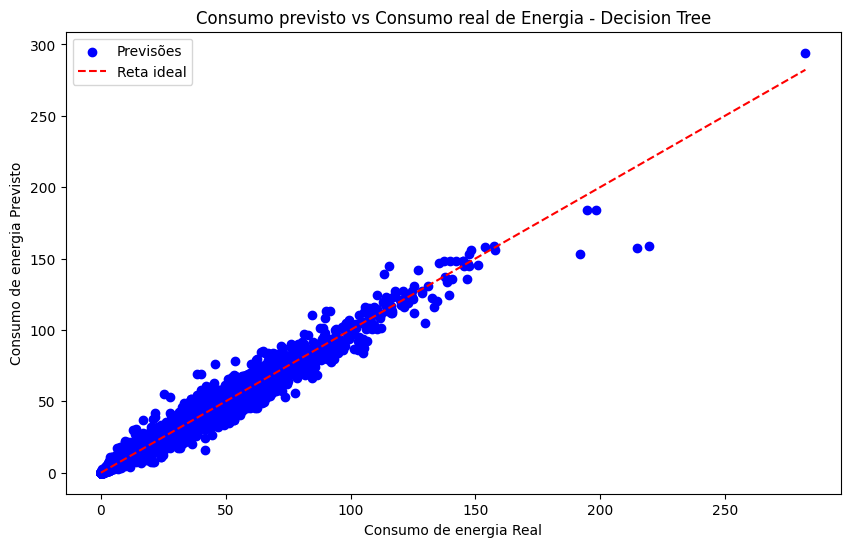

In [104]:
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, Y_pred, color='blue', label='Previsões')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linestyle='--', label='Reta ideal')
plt.xlabel('Consumo de energia Real')
plt.ylabel('Consumo de energia Previsto')
plt.title('Consumo previsto vs Consumo real de Energia - Decision Tree')
plt.legend()
plt.show()

### Random Forest

In [105]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

In [106]:
Y_pred = model.predict(X_test)

mae = mean_absolute_error(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 0.6694849608449615
Mean Squared Error (MSE): 1.4597164266726608
R-squared (R²): 0.9879312868774259


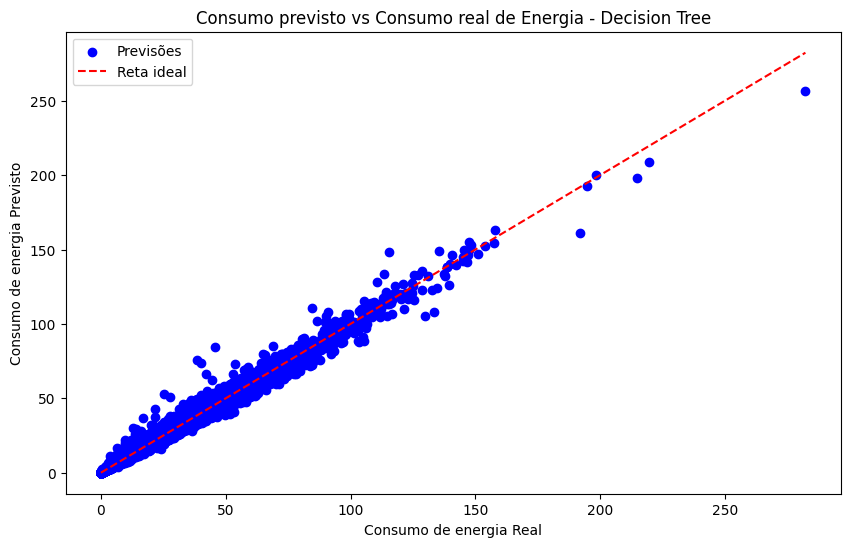

In [107]:
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, Y_pred, color='blue', label='Previsões')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linestyle='--', label='Reta ideal')
plt.xlabel('Consumo de energia Real')
plt.ylabel('Consumo de energia Previsto')
plt.title('Consumo previsto vs Consumo real de Energia - Decision Tree')
plt.legend()
plt.show()

### Artificial Neural Network

In [108]:
mlp = MLPRegressor(hidden_layer_sizes=(50,), activation='relu', solver='adam', max_iter=2000)
mlp.fit(X_train, Y_train)

MLPRegressor(hidden_layer_sizes=(50,), max_iter=2000)

In [109]:
Y_pred = mlp.predict(X_test)

mae = mean_absolute_error(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 0.617035284845665
Mean Squared Error (MSE): 1.2656694277988503
R-squared (R²): 0.9895356379136355


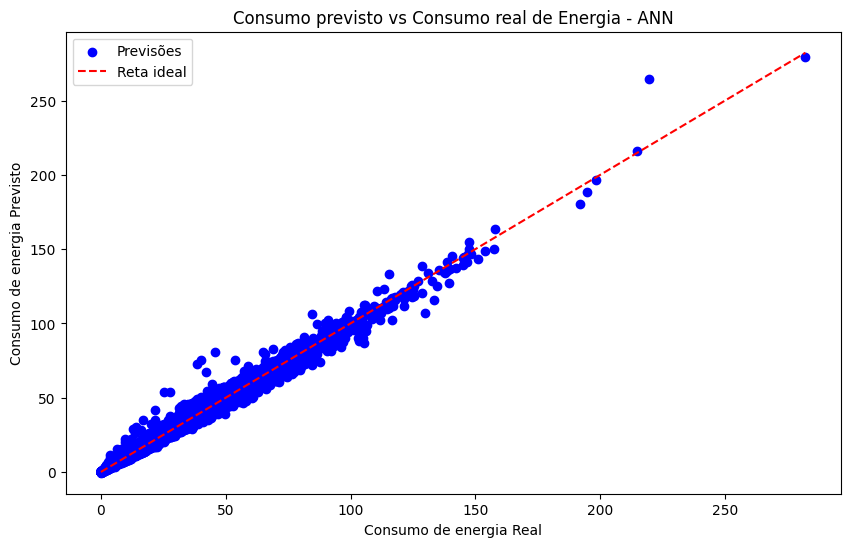

In [110]:
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, Y_pred, color='blue', label='Previsões')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linestyle='--', label='Reta ideal')
plt.xlabel('Consumo de energia Real')
plt.ylabel('Consumo de energia Previsto')
plt.title('Consumo previsto vs Consumo real de Energia - ANN')
plt.legend()
plt.show()

### SGD

In [111]:
reg = SGDRegressor(random_state=42)
reg.fit(X_train, Y_train)

SGDRegressor(random_state=42)

In [112]:
Y_pred = reg.predict(X_test)

mae = mean_absolute_error(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 0.6705781276887761
Mean Squared Error (MSE): 1.633249221525243
R-squared (R²): 0.9864965441560549


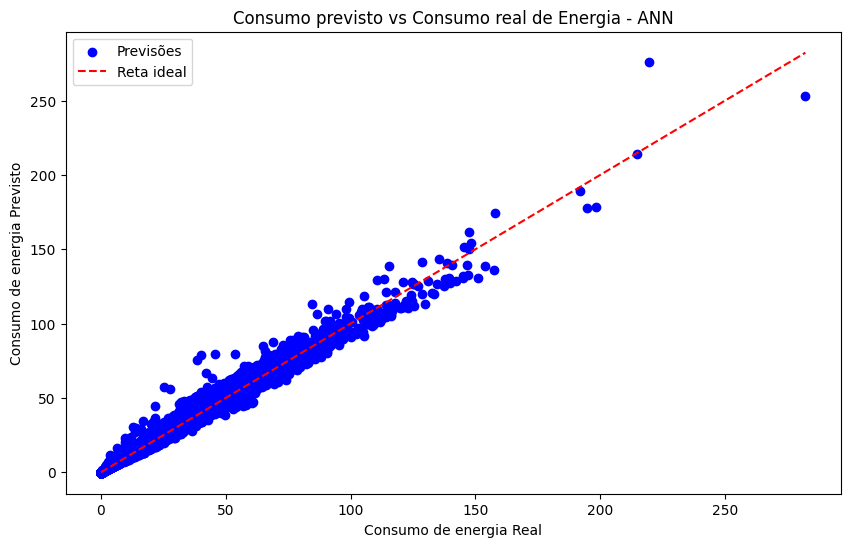

In [113]:
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, Y_pred, color='blue', label='Previsões')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linestyle='--', label='Reta ideal')
plt.xlabel('Consumo de energia Real')
plt.ylabel('Consumo de energia Previsto')
plt.title('Consumo previsto vs Consumo real de Energia - ANN')
plt.legend()
plt.show()

## Conclusões

